# Assignment II: Mask R-CNN vs YOLOv8
## Robert Chen, B20-AI
### r.chen@innopolis.university

# Dependencies for Colab

In [1]:
%matplotlib inline
!pip install roboflow
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

fatal: destination path 'detectron2' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 0. Imports

In [3]:
from roboflow import Roboflow
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
from PIL import Image
from datetime import datetime
# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
import glob

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# TRAINING
from detectron2.engine import DefaultTrainer
import cv2
from google.colab.patches import cv2_imshow

# 1. Mask R-CNN

Downloading the dataset

In [ ]:
rf = Roboflow(api_key="MajynWO1gWkBtWw9SHyL")
project = rf.workspace("b20ai").project("segmentation-syv4i")
dataset = project.version(1).download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Segmentation-1 in coco-segmentation:: 100%|██████████| 108/108 [00:00<00:00, 1513.22it/s]


Registering

In [ ]:
DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME,
    metadata={},
    json_file=TEST_DATA_SET_ANN_FILE_PATH,
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME,
    metadata={},
    json_file=VALID_DATA_SET_ANN_FILE_PATH,
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

Setting up configs and selecting a model from model zoo

In [ ]:
# HYPERPARAMETERS
ARCHITECTURE = "mask_rcnn_R_101_FPN_3x"
CONFIG_FILE_PATH = f"COCO-InstanceSegmentation/{ARCHITECTURE}.yaml"
MAX_ITER = 800
EVAL_PERIOD = 200
BASE_LR = 0.001
NUM_CLASSES = 3

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME,
    ARCHITECTURE,
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 30
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

Training

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/26 12:31:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
model_final_a3ec72.pkl: 254MB [00:01, 178MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[04/26 12:31:59 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


[04/26 12:32:25 d2.utils.events]:  eta: 0:05:47  iter: 19  total_loss: 3.039  loss_cls: 1.395  loss_box_reg: 0.9341  loss_mask: 0.6933  loss_rpn_cls: 0.007525  loss_rpn_loc: 0.006979    time: 0.4379  last_time: 0.4895  data_time: 0.1813  last_data_time: 0.0013   lr: 2.4726e-05  max_mem: 2462M
[04/26 12:32:40 d2.utils.events]:  eta: 0:05:31  iter: 39  total_loss: 2.781  loss_cls: 1.079  loss_box_reg: 1.008  loss_mask: 0.6786  loss_rpn_cls: 0.005036  loss_rpn_loc: 0.007921    time: 0.5058  last_time: 0.4041  data_time: 0.0130  last_data_time: 0.0063   lr: 4.9701e-05  max_mem: 2463M
[04/26 12:32:48 d2.utils.events]:  eta: 0:05:21  iter: 59  total_loss: 2.303  loss_cls: 0.7083  loss_box_reg: 0.9629  loss_mask: 0.6503  loss_rpn_cls: 0.008963  loss_rpn_loc: 0.007106    time: 0.4802  last_time: 0.4534  data_time: 0.0124  last_data_time: 0.0253   lr: 7.4676e-05  max_mem: 2463M
[04/26 12:32:57 d2.utils.events]:  eta: 0:05:09  iter: 79  total_loss: 2.083  loss_cls: 0.5549  loss_box_reg: 0.9356  

This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[04/26 12:34:01 d2.utils.events]:  eta: 0:04:17  iter: 219  total_loss: 0.6345  loss_cls: 0.1227  loss_box_reg: 0.3034  loss_mask: 0.1824  loss_rpn_cls: 7.468e-05  loss_rpn_loc: 0.006007    time: 0.4618  last_time: 0.5057  data_time: 0.0150  last_data_time: 0.0061   lr: 0.00027448  max_mem: 2463M
[04/26 12:34:10 d2.utils.events]:  eta: 0:04:09  iter: 239  total_loss: 0.5702  loss_cls: 0.09176  loss_box_reg: 0.2531  loss_mask: 0.1692  loss_rpn_cls: 3.983e-05  loss_rpn_loc: 0.00395    time: 0.4614  last_time: 0.4785  data_time: 0.0144  last_data_time: 0.0261   lr: 0.00029945  max_mem: 2463M
[04/26 12:34:20 d2.utils.events]:  eta: 0:04:00  iter: 259  total_loss: 0.5628  loss_cls: 0.09262  loss_box_reg: 0.283  loss_mask: 0.1941  loss_rpn_cls: 0.0002389  loss_rpn_loc: 0.005533    time: 0.4613  last_time: 0.4027  data_time: 0.0084  last_data_time: 0.0079   lr: 0.00032443  max_mem: 2463M
[04/26 12:34:29 d2.utils.events]:  eta: 0:03:52  iter: 279  total_loss: 0.5294  loss_cls: 0.08892  loss_bo

This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[04/26 12:35:34 d2.utils.events]:  eta: 0:02:51  iter: 419  total_loss: 0.443  loss_cls: 0.04548  loss_box_reg: 0.2171  loss_mask: 0.1515  loss_rpn_cls: 0.0001047  loss_rpn_loc: 0.003496    time: 0.4628  last_time: 0.5905  data_time: 0.0197  last_data_time: 0.0507   lr: 0.00052423  max_mem: 2463M
[04/26 12:35:44 d2.utils.events]:  eta: 0:02:43  iter: 439  total_loss: 0.3757  loss_cls: 0.04335  loss_box_reg: 0.1736  loss_mask: 0.1377  loss_rpn_cls: 1.898e-05  loss_rpn_loc: 0.003349    time: 0.4633  last_time: 0.4225  data_time: 0.0179  last_data_time: 0.0169   lr: 0.0005492  max_mem: 2463M
[04/26 12:35:53 d2.utils.events]:  eta: 0:02:34  iter: 459  total_loss: 0.3987  loss_cls: 0.05118  loss_box_reg: 0.1863  loss_mask: 0.1478  loss_rpn_cls: 4.751e-05  loss_rpn_loc: 0.004279    time: 0.4634  last_time: 0.5059  data_time: 0.0113  last_data_time: 0.0060   lr: 0.00057418  max_mem: 2463M
[04/26 12:36:03 d2.utils.events]:  eta: 0:02:25  iter: 479  total_loss: 0.355  loss_cls: 0.04833  loss_bo

This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[04/26 12:37:06 d2.utils.events]:  eta: 0:01:21  iter: 619  total_loss: 0.303  loss_cls: 0.04827  loss_box_reg: 0.1404  loss_mask: 0.1193  loss_rpn_cls: 5.669e-05  loss_rpn_loc: 0.003124    time: 0.4617  last_time: 0.5075  data_time: 0.0107  last_data_time: 0.0065   lr: 0.00077398  max_mem: 2463M
[04/26 12:37:16 d2.utils.events]:  eta: 0:01:12  iter: 639  total_loss: 0.2868  loss_cls: 0.03227  loss_box_reg: 0.1354  loss_mask: 0.12  loss_rpn_cls: 2.237e-05  loss_rpn_loc: 0.002623    time: 0.4620  last_time: 0.5103  data_time: 0.0167  last_data_time: 0.0139   lr: 0.00079895  max_mem: 2463M
[04/26 12:37:25 d2.utils.events]:  eta: 0:01:03  iter: 659  total_loss: 0.2926  loss_cls: 0.03697  loss_box_reg: 0.1388  loss_mask: 0.1108  loss_rpn_cls: 6.998e-05  loss_rpn_loc: 0.003106    time: 0.4614  last_time: 0.3906  data_time: 0.0089  last_data_time: 0.0166   lr: 0.00082393  max_mem: 2463M
[04/26 12:37:34 d2.utils.events]:  eta: 0:00:54  iter: 679  total_loss: 0.2801  loss_cls: 0.035  loss_box_

This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Evaluation

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator(TEST_DATA_SET_NAME, cfg, False, output_dir=OUTPUT_DIR_PATH)
val_loader = build_detection_test_loader(cfg, TEST_DATA_SET_NAME)
inference_on_dataset(trainer.model, val_loader, evaluator)

[04/26 12:38:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Segmentation/mask_rcnn_R_101_FPN_3x/2023-04-26-12-31-52/model_final.pth ...
[04/26 12:38:34 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [04/26 12:38:34 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/26 12:38:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/26 12:38:34 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/Segmentation-1/test/_annotations.coco.json
[04/26 12:38:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/26 12:38:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSeri

OrderedDict([('bbox',
              {'AP': 73.55345355964168,
               'AP50': 90.47029702970298,
               'AP75': 90.47029702970298,
               'APs': nan,
               'APm': nan,
               'APl': 73.55345355964168,
               'AP-asuka': 70.46263554926921,
               'AP-power': 76.64427157001414}),
             ('segm',
              {'AP': 61.21687883074022,
               'AP50': 90.47029702970298,
               'AP75': 81.06435643564357,
               'APs': nan,
               'APm': nan,
               'APl': 61.21687883074022,
               'AP-asuka': 59.73102310231023,
               'AP-power': 62.7027345591702})])

Visualizing

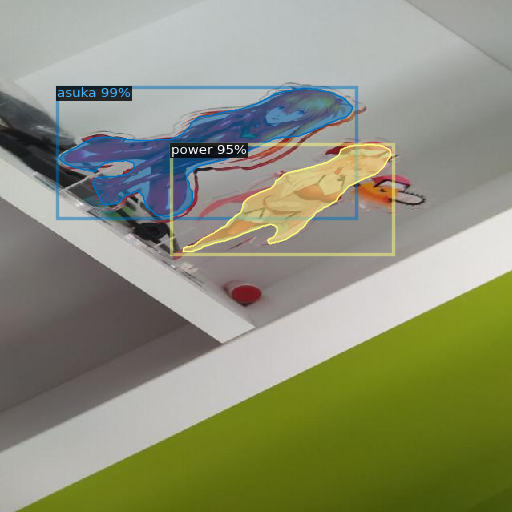

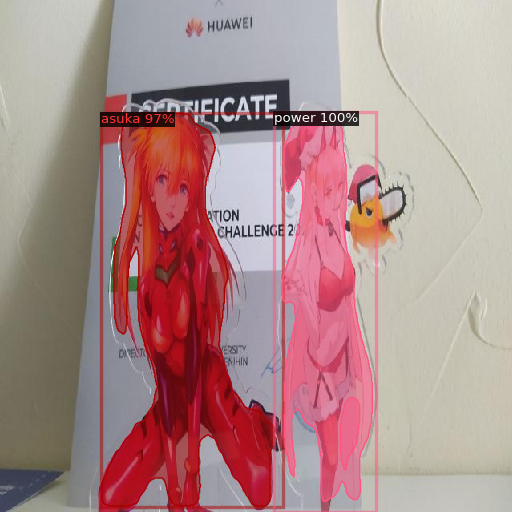

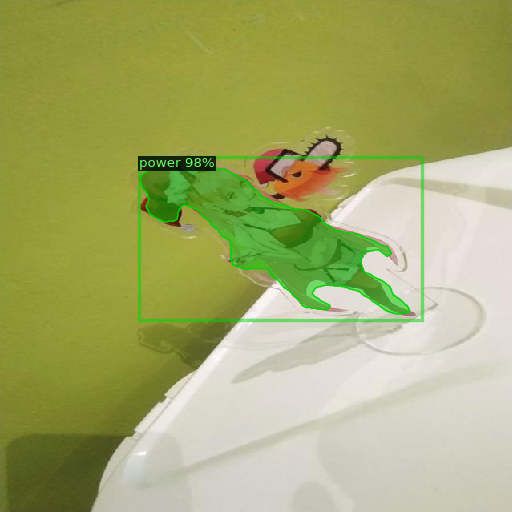

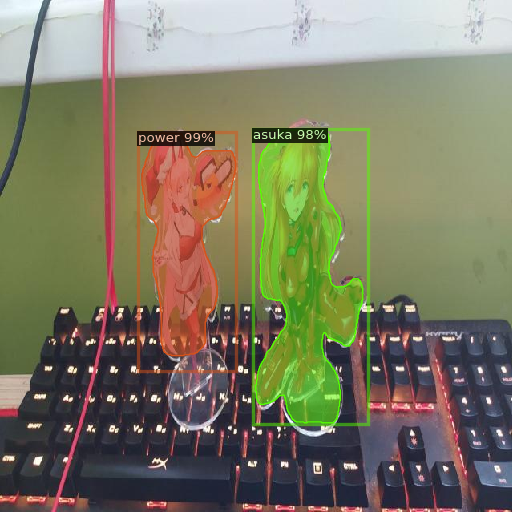

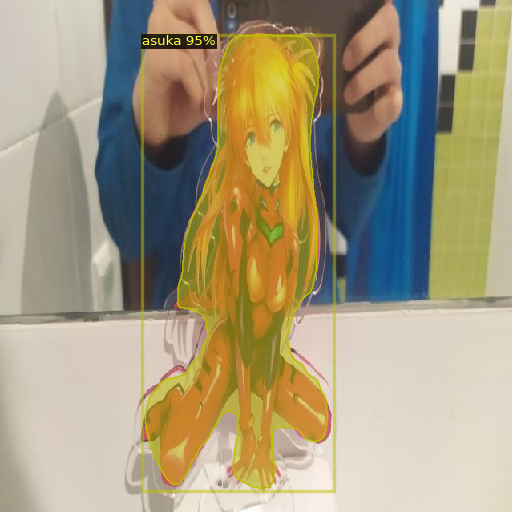

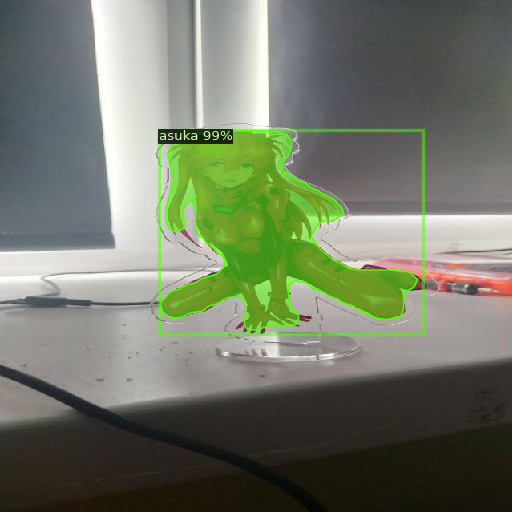

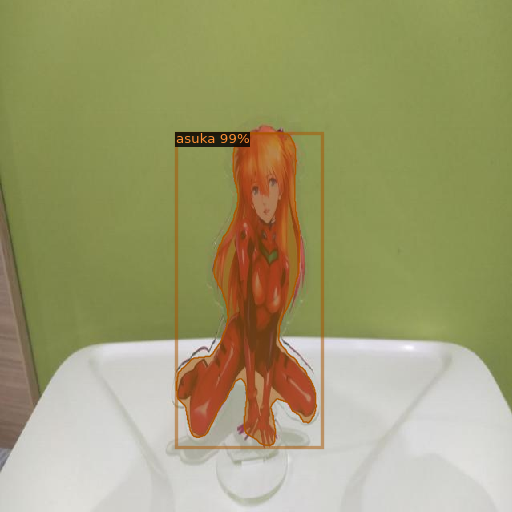

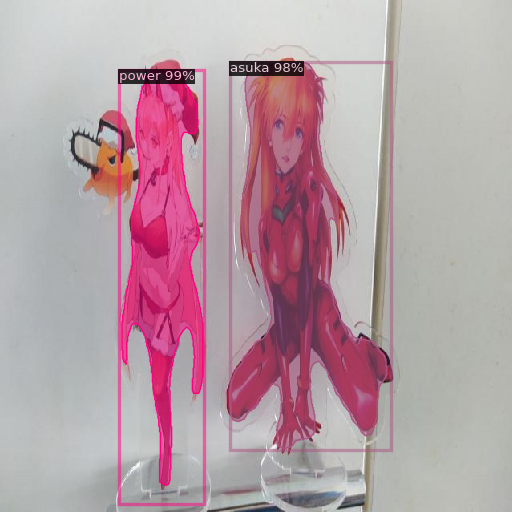

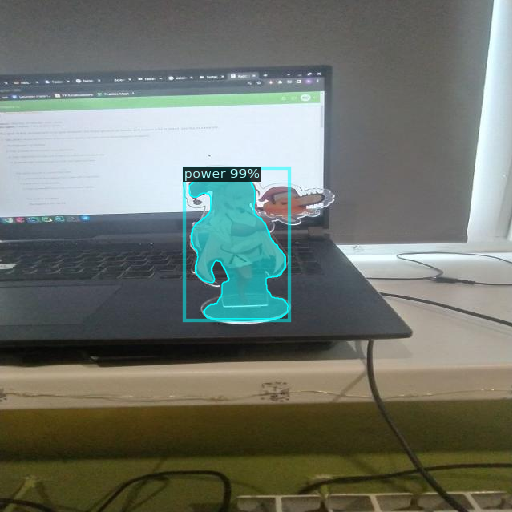

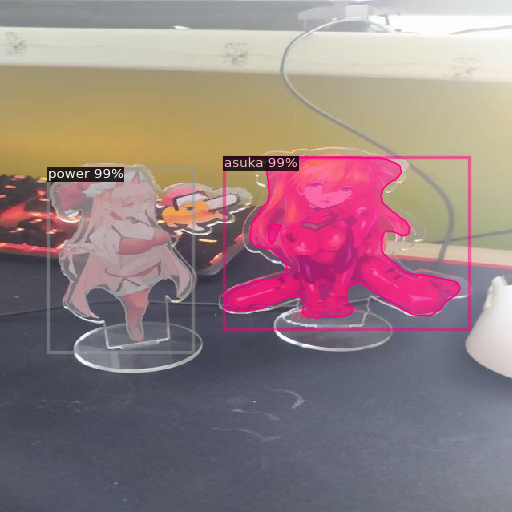

In [ ]:
test_metadata = MetadataCatalog.get(TEST_DATA_SET_NAME)

for imageName in glob.glob(f'/{dataset.location}/test/*jpg'):
    im = cv2.imread(imageName)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.8
                   )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

# 2. YOLOv8

Downloading the dataset

In [ ]:
dataset = project.version(1).download("yolov8")

Dependency ultralytics<=8.0.20 is required but found version=8.0.87, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to Segmentation-1 in yolov8:: 100%|██████████| 212/212 [00:00<00:00, 1409.42it/s]


Model training

In [ ]:
model = YOLO('yolov8n-seg.pt')

model.train(data=f'{dataset.location}/data.yaml', epochs=100, batch=20, imgsz=640)

100%|██████████| 6.73M/6.73M [00:00<00:00, 60.1MB/s]
Ultralytics YOLOv8.0.87 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/Segmentation-1/data.yaml, epochs=100, patience=50, batch=20, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torc

Model evaluation

In [ ]:
results = model(conf=0.4, save=True, source=f'{dataset.location}/test/images')

Visualizing

/content/runs/segment/predict/photo_1_2023-03-06_11-43-02_jpg.rf.00b6fe75a4a8b0d2259f63fdd0a1acdf.jpg
/content/runs/segment/predict/photo_9_2023-03-06_11-42-59_jpg.rf.a2e851f4ddfa7925ee2dbbe0dc95c9d4.jpg
/content/runs/segment/predict/photo_1_2023-03-06_11-42-24_jpg.rf.e7ded056dcace04c192e70f60360cec9.jpg
/content/runs/segment/predict/photo_2_2023-03-06_11-42-55_jpg.rf.e41ef570ec75d95aa89022bc3abd2c1e.jpg
/content/runs/segment/predict/photo_2_2023-03-06_11-39-40_jpg.rf.14d26f1641ef6bcd3f64e1997c51dde3.jpg
/content/runs/segment/predict/photo_1_2023-03-06_11-39-33_jpg.rf.db823b26a9e752e8da2195cd5f480c32.jpg
/content/runs/segment/predict/photo_7_2023-03-06_11-39-40_jpg.rf.71d56e16ad0d8246a5dd33bf67425cfd.jpg
/content/runs/segment/predict/photo_4_2023-03-06_11-42-59_jpg.rf.8d4b1f0bb41f0a6efdb3f23e0b7064f2.jpg
/content/runs/segment/predict/photo_2_2023-03-06_11-42-24_jpg.rf.cc3649a4cea35cd6994e2a28af90fee8.jpg
/content/runs/segment/predict/photo_9_2023-03-06_11-42-39_jpg.rf.4a86999b29b13e75b

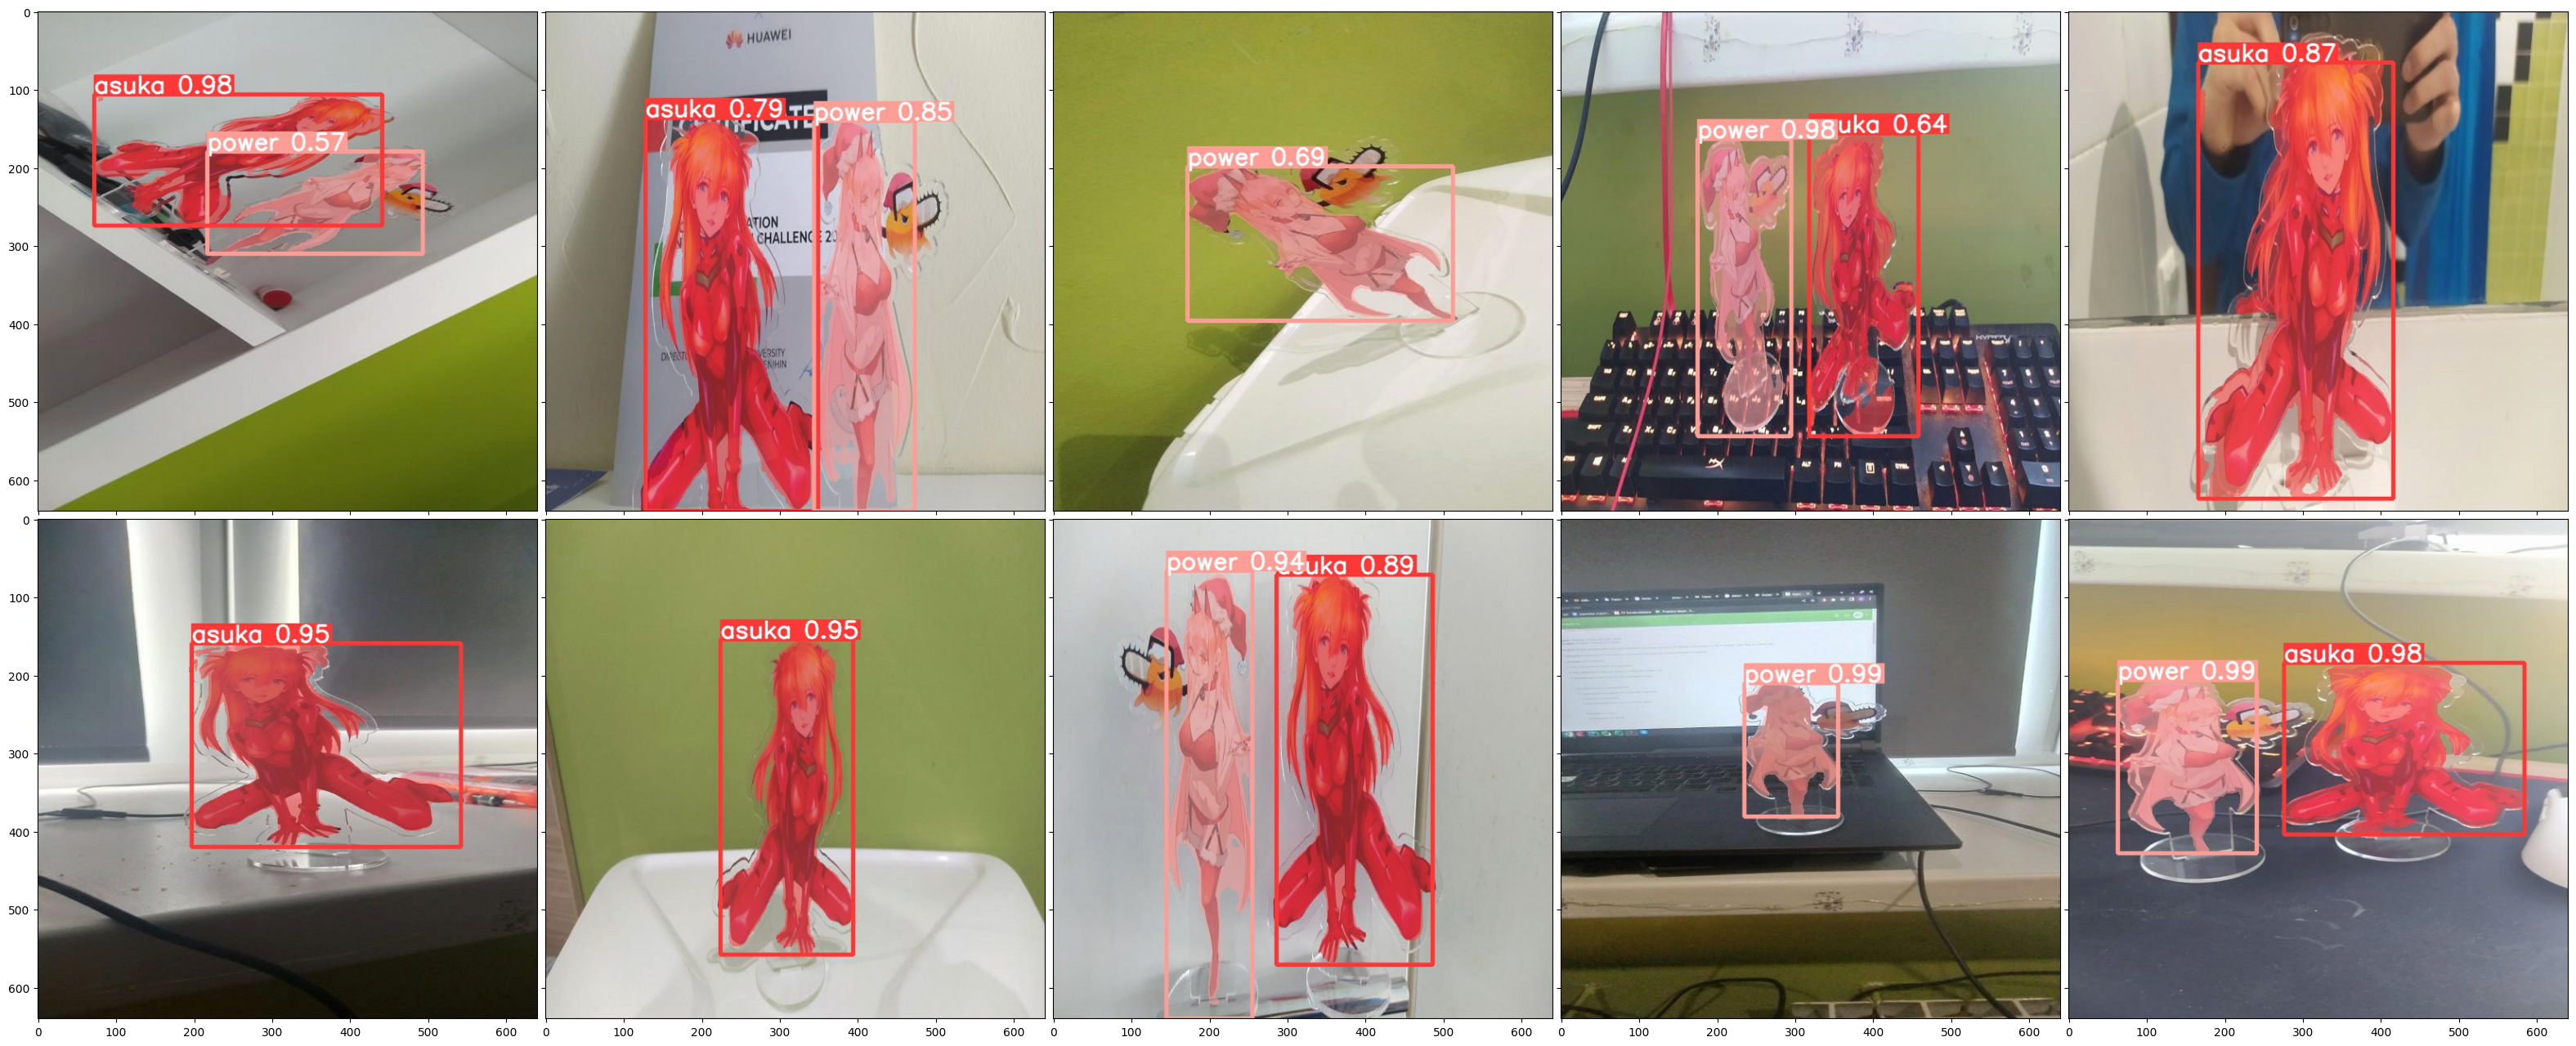

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(60, 16))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x5 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

path = os.path.join('/', 'content', 'runs', 'segment', 'predict')

filenames = []
for txt in os.listdir(path):
  filenames.append(os.path.join(path, txt))

for ax, result in zip(grid, filenames):
  print(result)
  ax.imshow(Image.open(result))
  ax.grid(False)

plt.grid(False)
plt.show()

# 3. Conclusion

For Mask R-CNN:
- mAP50-95: bbox - 0.73, mask - 0.61
- Training time: 6m15s
- Total inference time (10 images): 1s530ms
For YOLOv8
- mAP50-95: bbox - 0.821, mask - 0.717
- Training time: ~7m
- Total inference time (10 images): 39ms

Once again, YOLOv8 is superior almost in every single metric. Inference time for YOLOv8 is 39 times faster than Mask R-CNN, furthermore, mAP is 10% higher in both bounding box and mask metrics. Although Mask R-CNN took less time to train in general, it needed 798 iterations to converge, opposing to 100 for YOLOv8.